In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import pandas as pd
import time
import os
import pickle
import json
import timeit
import datetime
from copy import deepcopy as copy

In [2]:
import torch
from torch.nn import functional as F
torch.cuda.empty_cache()
DTYPE = torch.float32
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
DEVICE

device(type='cuda', index=0)

In [3]:
import sys
sys.path.append('../../')

In [4]:
import IPS_surrogate_util as util

In [5]:
beam_frequency = 80.5e6
wavelength = 299792458 / beam_frequency
phase_scan = np.arange(256)/256*2*np.pi-np.pi

cav_type_name = 'QWR085' 

In [6]:
WuLEVEL = 12
TEST = False

BATCH_SIZE = 2**13 #8192
LR = '1E-4'
DROPOUT = False

validation_split = 0.3
hidden_nodes = [128,64,64,64,64]
linear_nodes = 256
activation = torch.nn.ELU()

lr_scheduler = {'final_div_factor':1e3}

In [7]:
import sys
sys.path.insert(0, '/home/hwang/libIPS')

from info import info
for k,v in info.items():
    print(k)
    for k_,v_ in v.items():
        print(' ',k_+' '*(22-len(k_)),v_)

QWR041
  W_u_range              [450000.0, 3500000.0]
  field_amplitude_range  [0.0, 6.0]
  cav_length             0.24
  qA_range               [0.1, 0.6]
  nLEVEL                 16
QWR085
  W_u_range              [1000000.0, 33000000.0]
  field_amplitude_range  [0.0, 6.0]
  cav_length             0.32
  qA_range               [0.1, 0.6]
  nLEVEL                 16
QWR029
  W_u_range              [12000000.0, 75000000.0]
  field_amplitude_range  [0.0, 8.0]
  cav_length             0.33
  qA_range               [0.2, 0.6]
  nLEVEL                 4
QWR053
  W_u_range              [35000000.0, 320000000.0]
  field_amplitude_range  [0.0, 8.0]
  cav_length             0.49
  qA_range               [0.2, 0.6]
  nLEVEL                 4
MGB
  W_u_range              [10000000.0, 30000000.0]
  field_amplitude_range  [0.0, 8.5]
  cav_length             1.2
  qA_range               [0.2, 0.6]
  nLEVEL                 4


In [8]:
W_u_range = info[cav_type_name]['W_u_range']
field_amplitude_range = info[cav_type_name]['field_amplitude_range']
qA_range = info[cav_type_name]['qA_range']
cav_length = info[cav_type_name]['cav_length']
nLEVEL = info[cav_type_name]['nLEVEL']

In [9]:
dW_LEVEL = (W_u_range[1]-W_u_range[0])/nLEVEL
W_u_min = W_u_range[0] +WuLEVEL*dW_LEVEL 
W_u_max = W_u_range[0] +WuLEVEL*dW_LEVEL + 1.0*dW_LEVEL

In [10]:
DATA_PATH = "./data/"
MODEL_PATH = "./WuLEVEL"+str(WuLEVEL)#+"_batchsize"+str(BATCH_SIZE)+"_lr"+LR+'_'+'dtype'+str(DTYPE)[-2:]
if DTYPE == torch.float64:
    MODEL_PATH += '_dtype'+str(DTYPE)[-2:]
MODEL_PATH += '/'
LR = float(LR)
os.makedirs(MODEL_PATH, exist_ok=True)

In [11]:
EPOCHs = 6000  # may increase later... 
if TEST:
    EPOCHs = 100 #int(0.01*EPOCHs)

In [12]:
def Wu2beta(w_u):
    gamma = 1.+w_u/931.5e6
    return np.sqrt(1.0 - 1.0 / gamma ** 2)
def beta2Wu(beta):
    gamma = np.sqrt(1./(1.-beta**2))
    return (gamma-1.)*931.5e6

# Read data of selected Wu level

In [13]:
fname = os.path.join(DATA_PATH,cav_type_name+'_pd'+str(WuLEVEL)+'.pkl')
# fname = os.path.join('./',cav_type_name+'_pd'+str(WuLEVEL)+'.pkl')
df = pd.DataFrame(pickle.load(open(fname,'rb')))
df.columns

Index(['phase', 'W/u in', 'Cav amplitude in', 'qA', 'dTau', 'dW_u'], dtype='object')

### construct minmax scalar

In [14]:
Y_LABELs = ['dTau', 'dW_u']
y = df[Y_LABELs].values

Y_MIN = y.min(axis=0) #util.format_floats(y.min(axis=0),num_digits=4)
Y_MAX = y.max(axis=0) #util.format_floats(y.max(axis=0),num_digits=4)
print("Y_LABELs",Y_LABELs)
print("Y_MIN",Y_MIN)
print("Y_MAX",Y_MAX)
print("y.shape",y.shape)

Y_LABELs ['dTau', 'dW_u']
Y_MIN [-1.90706438e-02 -6.59460598e+05]
Y_MAX [1.84544862e-02 6.52206568e+05]
y.shape (134217728, 2)


In [15]:
X_LABELs = ['phase', 'W/u in', 'Cav amplitude in', 'qA']
x = df[X_LABELs].values

X_MIN = [ 0,W_u_min,                       0, qA_range[0]]
X_MAX = [ 1,W_u_max,field_amplitude_range[1], qA_range[1]] 

print("X_LABELs",X_LABELs)
print("X_MIN",X_MIN)
print("X_MAX",X_MAX)

X_LABELs ['phase', 'W/u in', 'Cav amplitude in', 'qA']
X_MIN [0, 25000000.0, 0, 0.1]
X_MAX [1, 27000000.0, 6.0, 0.6]


In [16]:
normalization_info = {'xmin':X_MIN,'xmax':X_MAX,
                      'ymin':Y_MIN,'ymax':Y_MAX,
                      'fname':MODEL_PATH+'scalar_info.pkl'}
scalar = util.scalar(**normalization_info)

### apply normalization

In [17]:
# p = np.random.permutation(len(x))
# x = x[p]
# y = y[p]

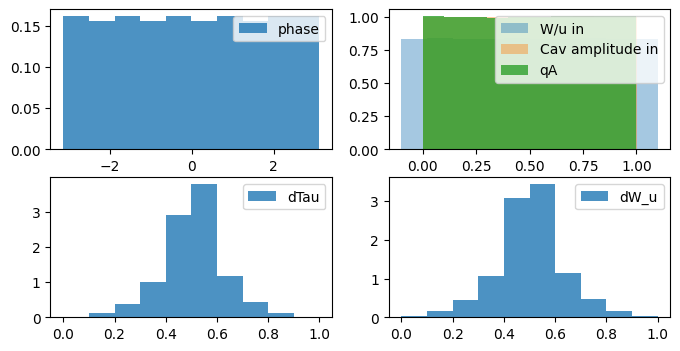

In [18]:
xn = scalar.normalize_x(x)
yn = scalar.normalize_y(y)
fig,ax = plt.subplots(2,2,figsize=(8,4))
ax[0,0].hist(xn[:,0],alpha=0.8,density=True,label=X_LABELs[0]);
ax[0,0].legend()
ax[0,1].hist(xn[:,1],alpha=0.4,density=True,label=X_LABELs[1]);
ax[0,1].hist(xn[:,2],alpha=0.4,density=True,label=X_LABELs[2]);
ax[0,1].hist(xn[:,3],alpha=0.8,density=True,label=X_LABELs[3]);
ax[0,1].legend()
ax[1,0].hist(yn[:,0],alpha=0.8,density=True,label=Y_LABELs[0]);
ax[1,0].legend()
ax[1,1].hist(yn[:,1],alpha=0.8,density=True,label=Y_LABELs[1]);
ax[1,1].legend()

# Train 

In [19]:
model, model_info = util.construct_model(
                                        input_dim  = xn.shape[1],
                                        output_dim  = yn.shape[1],
                                        input_phase_feature_dim = 1,        
                                        linear_nodes = linear_nodes,
                                        hidden_nodes = hidden_nodes,
                                        activation = activation)
model.to(DEVICE).to(DTYPE);

In [20]:
p = model.parameters().__next__()
p.dtype, p.device

(torch.float32, device(type='cuda', index=0))

In [21]:
json.dump(model_info,open(MODEL_PATH+'model_info.json','w'))
model_info

{'input_dim': 4,
 'output_dim': 2,
 'input_phase_feature_dim': 1,
 'linear_nodes': [256],
 'hidden_nodes': [128, 64, 64, 64, 64],
 'activation': 'ELU'}

In [22]:
torch.nn.MSELoss.__name__

'MSELoss'

In [23]:
train_info = {
    'epochs':EPOCHs,
    'lr':LR,
    'batch_size':BATCH_SIZE,
    'criterion': torch.nn.MSELoss.__name__,
    'optimizer': torch.optim.Adam.__name__,
    'optim_args': None,
    'lr_scheduler': lr_scheduler,
    'dropout_stabilization': DROPOUT,
    'shuffle':True,
    'load_best':True,
    'validation_split':validation_split,
    'fname_model'  : MODEL_PATH + 'model.pt',
    'fname_opt'    : MODEL_PATH + 'optimizer.pt',
    'fname_history': MODEL_PATH + 'train_history.pkl'\
}

In [ ]:
history,model_state_dict,opt_state_dict = util.train(
    model,xn,yn,
    **train_info,
    verbose = True,
    )

Train Function Arguments: 2024-04-18 17:26
  - model: _ModelWithPhaseInput
  - x: (134217728, 4)
  - y: (134217728, 2)
  - epochs: 6000
  - lr: 0.0001
  - batch_size: 8192
  - shuffle: True
  - validation_split: 0.3
  - criterion: MSELoss
  - optimizer: Adam
  - optim_args: None
  - optimizer_state_dict: None
  - lr_scheduler: {'final_div_factor': 1000.0}
  - dropout_stabilization: False
  - prev_history: None
  - load_best: True
  - training_timeout: inf
  - verbose: True
  - fname_model: ./WuLEVEL12/model.pt
  - fname_opt: ./WuLEVEL12/optimizer.pt
  - fname_history: ./WuLEVEL12/train_history.pkl

Model Paramers:
  - name: linear_base.0.weight, shape: torch.Size([256, 5]), dtype: torch.float32, device: cuda:0
  - name: linear_base.0.bias, shape: torch.Size([256]), dtype: torch.float32, device: cuda:0
  - name: linear_base.1.weight, shape: torch.Size([2, 256]), dtype: torch.float32, device: cuda:0
  - name: linear_base.1.bias, shape: torch.Size([2]), dtype: torch.float32, device: cuda:

 Epoch 0067: | Train Loss: 8.12E-08 | Val Loss: 6.34E-08 | lr: 1.92E-05 | 0:33:31.959538
 Epoch 0068: | Train Loss: 8.18E-08 | Val Loss: 5.91E-08 | lr: 1.95E-05 | 0:34:03.208793
 Epoch 0069: | Train Loss: 8.17E-08 | Val Loss: 9.24E-08 | lr: 1.98E-05 | 0:34:35.629281
 Epoch 0070: | Train Loss: 8.26E-08 | Val Loss: 8.59E-08 | lr: 2.01E-05 | 0:35:02.535563
 Epoch 0071: | Train Loss: 8.25E-08 | Val Loss: 6.16E-08 | lr: 2.04E-05 | 0:35:32.361927
 Epoch 0072: | Train Loss: 8.31E-08 | Val Loss: 6.54E-08 | lr: 2.08E-05 | 0:36:04.674686
 Epoch 0073: | Train Loss: 8.38E-08 | Val Loss: 6.09E-08 | lr: 2.11E-05 | 0:36:31.777330
 Epoch 0074: | Train Loss: 8.46E-08 | Val Loss: 8.05E-08 | lr: 2.14E-05 | 0:37:07.859327
 Epoch 0075: | Train Loss: 8.52E-08 | Val Loss: 6.51E-08 | lr: 2.18E-05 | 0:37:41.589699
 Epoch 0076: | Train Loss: 8.58E-08 | Val Loss: 7.21E-08 | lr: 2.21E-05 | 0:38:18.567082
 Epoch 0077: | Train Loss: 8.65E-08 | Val Loss: 1.54E-07 | lr: 2.24E-05 | 0:38:44.522449
 Epoch 0078: | Train 

 Epoch 0160: | Train Loss: 3.39E-07 | Val Loss: 1.45E-06 | lr: 5.90E-05 | 1:22:33.966018
 Epoch 0161: | Train Loss: 3.44E-07 | Val Loss: 7.65E-08 | lr: 5.94E-05 | 1:23:03.146653
 Epoch 0162: | Train Loss: 3.48E-07 | Val Loss: 6.62E-08 | lr: 5.99E-05 | 1:23:29.766267
 Epoch 0163: | Train Loss: 3.49E-07 | Val Loss: 7.83E-08 | lr: 6.04E-05 | 1:23:55.855959
 Epoch 0164: | Train Loss: 3.54E-07 | Val Loss: 3.60E-07 | lr: 6.09E-05 | 1:24:26.270418
 Epoch 0165: | Train Loss: 3.58E-07 | Val Loss: 1.22E-07 | lr: 6.13E-05 | 1:24:58.224240
 Epoch 0166: | Train Loss: 3.61E-07 | Val Loss: 6.40E-08 | lr: 6.18E-05 | 1:25:32.933331
 Epoch 0167: | Train Loss: 3.63E-07 | Val Loss: 9.81E-08 | lr: 6.23E-05 | 1:26:08.404512
 Epoch 0168: | Train Loss: 3.68E-07 | Val Loss: 6.69E-07 | lr: 6.28E-05 | 1:26:38.367783
 Epoch 0169: | Train Loss: 3.70E-07 | Val Loss: 7.14E-08 | lr: 6.32E-05 | 1:27:12.393446
 Epoch 0170: | Train Loss: 3.73E-07 | Val Loss: 6.72E-07 | lr: 6.37E-05 | 1:27:40.623520
 Epoch 0171: | Train 

 Epoch 0253: | Train Loss: 3.71E-07 | Val Loss: 3.93E-08 | lr: 9.46E-05 | 2:07:42.012286
 Epoch 0254: | Train Loss: 3.68E-07 | Val Loss: 4.16E-07 | lr: 9.48E-05 | 2:08:07.305599
 Epoch 0255: | Train Loss: 3.68E-07 | Val Loss: 1.31E-07 | lr: 9.50E-05 | 2:08:32.573678
 Epoch 0256: | Train Loss: 3.63E-07 | Val Loss: 4.70E-08 | lr: 9.52E-05 | 2:08:58.095362
 Epoch 0257: | Train Loss: 3.63E-07 | Val Loss: 4.43E-08 | lr: 9.54E-05 | 2:09:24.460189
 Epoch 0258: | Train Loss: 3.58E-07 | Val Loss: 5.16E-07 | lr: 9.56E-05 | 2:09:50.926750
 Epoch 0259: | Train Loss: 3.58E-07 | Val Loss: 7.21E-08 | lr: 9.58E-05 | 2:10:21.794685
 Epoch 0260: | Train Loss: 3.55E-07 | Val Loss: 3.86E-07 | lr: 9.60E-05 | 2:10:52.832654
 Epoch 0261: | Train Loss: 3.52E-07 | Val Loss: 3.99E-08 | lr: 9.62E-05 | 2:11:19.287513
 Epoch 0262: | Train Loss: 3.51E-07 | Val Loss: 8.26E-08 | lr: 9.64E-05 | 2:11:45.251067
 Epoch 0263: | Train Loss: 3.47E-07 | Val Loss: 2.12E-07 | lr: 9.66E-05 | 2:12:11.499725
 Epoch 0264: | Train 

 Epoch 0346: | Train Loss: 1.86E-07 | Val Loss: 2.67E-08 | lr: 1.00E-04 | 2:48:47.942341
 Epoch 0347: | Train Loss: 1.86E-07 | Val Loss: 7.18E-07 | lr: 1.00E-04 | 2:49:13.871353
 Epoch 0348: | Train Loss: 1.84E-07 | Val Loss: 2.72E-08 | lr: 1.00E-04 | 2:49:39.266605
 Epoch 0349: | Train Loss: 1.84E-07 | Val Loss: 5.73E-07 | lr: 1.00E-04 | 2:50:04.565940
 Epoch 0350: | Train Loss: 1.83E-07 | Val Loss: 7.25E-08 | lr: 1.00E-04 | 2:50:31.645462
 Epoch 0351: | Train Loss: 1.81E-07 | Val Loss: 1.33E-07 | lr: 1.00E-04 | 2:50:58.496038
 Epoch 0352: | Train Loss: 1.81E-07 | Val Loss: 1.15E-07 | lr: 1.00E-04 | 2:51:24.137084
 Epoch 0353: | Train Loss: 1.79E-07 | Val Loss: 4.58E-08 | lr: 1.00E-04 | 2:51:49.982153
 Epoch 0354: | Train Loss: 1.78E-07 | Val Loss: 6.13E-07 | lr: 1.00E-04 | 2:52:16.138306
 Epoch 0355: | Train Loss: 1.78E-07 | Val Loss: 1.58E-08 | lr: 1.00E-04 | 2:52:42.385215
 Epoch 0356: | Train Loss: 1.76E-07 | Val Loss: 6.24E-08 | lr: 1.00E-04 | 2:53:07.773621
 Epoch 0357: | Train 

 Epoch 0439: | Train Loss: 1.14E-07 | Val Loss: 1.36E-07 | lr: 9.99E-05 | 3:33:43.746480
 Epoch 0440: | Train Loss: 1.15E-07 | Val Loss: 1.06E-07 | lr: 9.99E-05 | 3:34:10.823763
 Epoch 0441: | Train Loss: 1.13E-07 | Val Loss: 1.99E-08 | lr: 9.98E-05 | 3:34:37.071644
 Epoch 0442: | Train Loss: 1.13E-07 | Val Loss: 2.80E-07 | lr: 9.98E-05 | 3:35:03.853598
 Epoch 0443: | Train Loss: 1.13E-07 | Val Loss: 3.02E-08 | lr: 9.98E-05 | 3:35:30.453017
 Epoch 0444: | Train Loss: 1.12E-07 | Val Loss: 3.09E-08 | lr: 9.98E-05 | 3:36:08.926375
 Epoch 0445: | Train Loss: 1.12E-07 | Val Loss: 1.37E-08 | lr: 9.98E-05 | 3:36:44.753234
 Epoch 0446: | Train Loss: 1.11E-07 | Val Loss: 1.50E-08 | lr: 9.98E-05 | 3:37:25.517385
 Epoch 0447: | Train Loss: 1.11E-07 | Val Loss: 4.70E-08 | lr: 9.98E-05 | 3:38:02.091264
 Epoch 0448: | Train Loss: 1.10E-07 | Val Loss: 1.40E-07 | lr: 9.98E-05 | 3:38:40.110262
 Epoch 0449: | Train Loss: 1.10E-07 | Val Loss: 3.20E-08 | lr: 9.98E-05 | 3:39:16.418229
 Epoch 0450: | Train 

 Epoch 0532: | Train Loss: 7.80E-08 | Val Loss: 7.33E-09 | lr: 9.96E-05 | 4:30:24.632018
 Epoch 0533: | Train Loss: 7.76E-08 | Val Loss: 4.17E-08 | lr: 9.96E-05 | 4:30:59.755708
 Epoch 0534: | Train Loss: 7.75E-08 | Val Loss: 1.36E-08 | lr: 9.96E-05 | 4:31:34.477841
 Epoch 0535: | Train Loss: 7.73E-08 | Val Loss: 1.46E-08 | lr: 9.96E-05 | 4:32:13.626479
 Epoch 0536: | Train Loss: 7.70E-08 | Val Loss: 7.31E-08 | lr: 9.96E-05 | 4:32:53.067733
 Epoch 0537: | Train Loss: 7.67E-08 | Val Loss: 4.19E-08 | lr: 9.96E-05 | 4:33:34.054696
 Epoch 0538: | Train Loss: 7.61E-08 | Val Loss: 3.18E-08 | lr: 9.96E-05 | 4:34:12.791420
 Epoch 0539: | Train Loss: 7.62E-08 | Val Loss: 1.76E-08 | lr: 9.96E-05 | 4:34:50.541691
 Epoch 0540: | Train Loss: 7.57E-08 | Val Loss: 3.28E-08 | lr: 9.96E-05 | 4:35:25.740513
 Epoch 0541: | Train Loss: 7.55E-08 | Val Loss: 2.54E-08 | lr: 9.96E-05 | 4:36:02.541436
 Epoch 0542: | Train Loss: 7.53E-08 | Val Loss: 1.49E-07 | lr: 9.96E-05 | 4:36:37.907649
 Epoch 0543: | Train 

 Epoch 0625: | Train Loss: 5.52E-08 | Val Loss: 1.60E-08 | lr: 9.92E-05 | 5:27:03.425929
 Epoch 0626: | Train Loss: 5.51E-08 | Val Loss: 1.03E-08 | lr: 9.92E-05 | 5:27:39.053172
 Epoch 0627: | Train Loss: 5.49E-08 | Val Loss: 1.22E-07 | lr: 9.92E-05 | 5:28:13.829982
 Epoch 0628: | Train Loss: 5.47E-08 | Val Loss: 8.80E-08 | lr: 9.92E-05 | 5:28:47.108245
 Epoch 0629: | Train Loss: 5.44E-08 | Val Loss: 1.18E-07 | lr: 9.92E-05 | 5:29:14.898814
 Epoch 0630: | Train Loss: 5.44E-08 | Val Loss: 4.70E-08 | lr: 9.92E-05 | 5:29:41.317163
 Epoch 0631: | Train Loss: 5.42E-08 | Val Loss: 2.61E-08 | lr: 9.92E-05 | 5:30:08.706929
 Epoch 0632: | Train Loss: 5.39E-08 | Val Loss: 8.96E-08 | lr: 9.92E-05 | 5:30:34.263596
 Epoch 0633: | Train Loss: 5.37E-08 | Val Loss: 3.20E-07 | lr: 9.92E-05 | 5:30:59.930312
 Epoch 0634: | Train Loss: 5.36E-08 | Val Loss: 1.30E-08 | lr: 9.92E-05 | 5:31:25.375685
 Epoch 0635: | Train Loss: 5.38E-08 | Val Loss: 5.35E-09 | lr: 9.92E-05 | 5:31:50.798453
 Epoch 0636: | Train 

 Epoch 0718: | Train Loss: 3.98E-08 | Val Loss: 6.59E-08 | lr: 9.87E-05 | 6:10:54.506064
 Epoch 0719: | Train Loss: 3.98E-08 | Val Loss: 2.57E-08 | lr: 9.87E-05 | 6:11:20.016484
 Epoch 0720: | Train Loss: 3.95E-08 | Val Loss: 2.28E-08 | lr: 9.87E-05 | 6:11:45.915466
 Epoch 0721: | Train Loss: 3.95E-08 | Val Loss: 1.04E-08 | lr: 9.87E-05 | 6:12:11.872981
 Epoch 0722: | Train Loss: 3.93E-08 | Val Loss: 8.02E-08 | lr: 9.87E-05 | 6:12:37.494901
 Epoch 0723: | Train Loss: 3.92E-08 | Val Loss: 6.33E-08 | lr: 9.86E-05 | 6:13:02.719905
 Epoch 0724: | Train Loss: 3.91E-08 | Val Loss: 7.55E-08 | lr: 9.86E-05 | 6:13:27.774464
 Epoch 0725: | Train Loss: 3.87E-08 | Val Loss: 6.04E-09 | lr: 9.86E-05 | 6:14:04.079430
 Epoch 0726: | Train Loss: 3.88E-08 | Val Loss: 7.58E-08 | lr: 9.86E-05 | 6:14:39.076902
 Epoch 0727: | Train Loss: 3.87E-08 | Val Loss: 5.75E-09 | lr: 9.86E-05 | 6:15:07.733139
 Epoch 0728: | Train Loss: 3.85E-08 | Val Loss: 9.18E-08 | lr: 9.86E-05 | 6:15:35.939762
 Epoch 0729: | Train 

 Epoch 0811: | Train Loss: 2.95E-08 | Val Loss: 8.09E-08 | lr: 9.80E-05 | 6:58:33.692226
 Epoch 0812: | Train Loss: 2.94E-08 | Val Loss: 8.13E-09 | lr: 9.80E-05 | 6:58:59.511363
 Epoch 0813: | Train Loss: 2.95E-08 | Val Loss: 4.04E-09 | lr: 9.80E-05 | 6:59:25.321751
 Epoch 0814: | Train Loss: 2.91E-08 | Val Loss: 3.68E-09 | lr: 9.80E-05 | 6:59:51.255716
 Epoch 0815: | Train Loss: 2.91E-08 | Val Loss: 1.09E-08 | lr: 9.80E-05 | 7:00:19.801850
 Epoch 0816: | Train Loss: 2.91E-08 | Val Loss: 4.28E-09 | lr: 9.80E-05 | 7:00:50.477427
 Epoch 0817: | Train Loss: 2.90E-08 | Val Loss: 1.31E-08 | lr: 9.80E-05 | 7:01:24.922650
 Epoch 0818: | Train Loss: 2.91E-08 | Val Loss: 2.09E-08 | lr: 9.80E-05 | 7:01:50.869540
 Epoch 0819: | Train Loss: 2.88E-08 | Val Loss: 3.86E-09 | lr: 9.80E-05 | 7:02:25.414509
 Epoch 0820: | Train Loss: 2.88E-08 | Val Loss: 8.12E-09 | lr: 9.80E-05 | 7:02:53.318073
 Epoch 0821: | Train Loss: 2.87E-08 | Val Loss: 2.02E-08 | lr: 9.80E-05 | 7:03:26.196555
 Epoch 0822: | Train 

 Epoch 0904: | Train Loss: 2.33E-08 | Val Loss: 2.84E-08 | lr: 9.73E-05 | 7:44:51.164070
 Epoch 0905: | Train Loss: 2.32E-08 | Val Loss: 1.43E-08 | lr: 9.72E-05 | 7:45:28.503589
 Epoch 0906: | Train Loss: 2.33E-08 | Val Loss: 5.23E-08 | lr: 9.72E-05 | 7:45:54.476673
 Epoch 0907: | Train Loss: 2.32E-08 | Val Loss: 1.03E-08 | lr: 9.72E-05 | 7:46:22.065538
 Epoch 0908: | Train Loss: 2.30E-08 | Val Loss: 1.33E-08 | lr: 9.72E-05 | 7:46:48.850462
 Epoch 0909: | Train Loss: 2.31E-08 | Val Loss: 4.76E-08 | lr: 9.72E-05 | 7:47:20.441423
 Epoch 0910: | Train Loss: 2.30E-08 | Val Loss: 6.70E-09 | lr: 9.72E-05 | 7:47:51.726741
 Epoch 0911: | Train Loss: 2.28E-08 | Val Loss: 1.84E-08 | lr: 9.72E-05 | 7:48:24.109851
 Epoch 0912: | Train Loss: 2.30E-08 | Val Loss: 2.19E-08 | lr: 9.72E-05 | 7:48:56.794505
 Epoch 0913: | Train Loss: 2.29E-08 | Val Loss: 1.14E-08 | lr: 9.72E-05 | 7:49:23.032164
 Epoch 0914: | Train Loss: 2.27E-08 | Val Loss: 1.38E-08 | lr: 9.72E-05 | 7:49:49.234556
 Epoch 0915: | Train 

 Epoch 0997: | Train Loss: 1.92E-08 | Val Loss: 1.90E-08 | lr: 9.64E-05 | 8:29:29.940624
 Epoch 0998: | Train Loss: 1.92E-08 | Val Loss: 5.73E-09 | lr: 9.63E-05 | 8:29:56.710925
 Epoch 0999: | Train Loss: 1.92E-08 | Val Loss: 3.02E-09 | lr: 9.63E-05 | 8:30:25.963897
 Epoch 1000: | Train Loss: 1.91E-08 | Val Loss: 4.53E-09 | lr: 9.63E-05 | 8:30:57.640801
 Epoch 1001: | Train Loss: 1.91E-08 | Val Loss: 7.43E-09 | lr: 9.63E-05 | 8:31:25.019047
 Epoch 1002: | Train Loss: 1.90E-08 | Val Loss: 9.25E-08 | lr: 9.63E-05 | 8:31:59.607491
 Epoch 1003: | Train Loss: 1.89E-08 | Val Loss: 2.45E-08 | lr: 9.63E-05 | 8:32:30.717363
 Epoch 1004: | Train Loss: 1.90E-08 | Val Loss: 2.80E-08 | lr: 9.63E-05 | 8:32:58.625950
 Epoch 1005: | Train Loss: 1.90E-08 | Val Loss: 8.84E-09 | lr: 9.63E-05 | 8:33:27.417853
 Epoch 1006: | Train Loss: 1.90E-08 | Val Loss: 3.68E-09 | lr: 9.63E-05 | 8:33:59.767655
 Epoch 1007: | Train Loss: 1.87E-08 | Val Loss: 5.08E-09 | lr: 9.63E-05 | 8:34:29.089806
 Epoch 1008: | Train 

 Epoch 1090: | Train Loss: 1.63E-08 | Val Loss: 2.92E-09 | lr: 9.53E-05 | 9:13:20.226267
 Epoch 1091: | Train Loss: 1.63E-08 | Val Loss: 4.96E-09 | lr: 9.53E-05 | 9:13:46.982880
 Epoch 1092: | Train Loss: 1.62E-08 | Val Loss: 1.63E-08 | lr: 9.53E-05 | 9:14:14.997201
 Epoch 1093: | Train Loss: 1.63E-08 | Val Loss: 5.61E-09 | lr: 9.53E-05 | 9:14:42.654719
 Epoch 1094: | Train Loss: 1.62E-08 | Val Loss: 2.76E-08 | lr: 9.53E-05 | 9:15:11.573955
 Epoch 1095: | Train Loss: 1.62E-08 | Val Loss: 3.32E-09 | lr: 9.53E-05 | 9:15:42.969318
 Epoch 1096: | Train Loss: 1.62E-08 | Val Loss: 1.64E-08 | lr: 9.53E-05 | 9:16:10.129492
 Epoch 1097: | Train Loss: 1.61E-08 | Val Loss: 3.79E-08 | lr: 9.53E-05 | 9:16:35.984958
 Epoch 1098: | Train Loss: 1.62E-08 | Val Loss: 1.38E-08 | lr: 9.52E-05 | 9:17:05.771959
 Epoch 1099: | Train Loss: 1.60E-08 | Val Loss: 3.77E-09 | lr: 9.52E-05 | 9:17:32.854959
 Epoch 1100: | Train Loss: 1.61E-08 | Val Loss: 3.67E-09 | lr: 9.52E-05 | 9:18:01.628038
 Epoch 1101: | Train 

 Epoch 1183: | Train Loss: 1.41E-08 | Val Loss: 2.50E-08 | lr: 9.42E-05 | 9:56:08.291371
 Epoch 1184: | Train Loss: 1.41E-08 | Val Loss: 5.40E-09 | lr: 9.42E-05 | 9:56:39.428287
 Epoch 1185: | Train Loss: 1.40E-08 | Val Loss: 1.68E-08 | lr: 9.42E-05 | 9:57:10.998907
 Epoch 1186: | Train Loss: 1.41E-08 | Val Loss: 8.92E-09 | lr: 9.42E-05 | 9:57:41.000030
 Epoch 1187: | Train Loss: 1.40E-08 | Val Loss: 7.04E-09 | lr: 9.41E-05 | 9:58:15.551088
 Epoch 1188: | Train Loss: 1.40E-08 | Val Loss: 1.31E-08 | lr: 9.41E-05 | 9:58:44.497856
 Epoch 1189: | Train Loss: 1.40E-08 | Val Loss: 2.28E-08 | lr: 9.41E-05 | 9:59:16.118643
 Epoch 1190: | Train Loss: 1.40E-08 | Val Loss: 3.62E-08 | lr: 9.41E-05 | 9:59:47.049908
 Epoch 1191: | Train Loss: 1.39E-08 | Val Loss: 4.08E-09 | lr: 9.41E-05 | 10:00:17.247677
 Epoch 1192: | Train Loss: 1.39E-08 | Val Loss: 4.07E-09 | lr: 9.41E-05 | 10:00:47.618576
 Epoch 1193: | Train Loss: 1.39E-08 | Val Loss: 1.03E-08 | lr: 9.41E-05 | 10:01:18.883784
 Epoch 1194: | Tra

 Epoch 1275: | Train Loss: 1.23E-08 | Val Loss: 2.97E-09 | lr: 9.30E-05 | 10:40:19.565879
 Epoch 1276: | Train Loss: 1.23E-08 | Val Loss: 2.61E-09 | lr: 9.29E-05 | 10:40:44.674864
 Epoch 1277: | Train Loss: 1.23E-08 | Val Loss: 7.23E-09 | lr: 9.29E-05 | 10:41:11.355653
 Epoch 1278: | Train Loss: 1.23E-08 | Val Loss: 3.53E-09 | lr: 9.29E-05 | 10:41:38.065747
 Epoch 1279: | Train Loss: 1.22E-08 | Val Loss: 2.08E-08 | lr: 9.29E-05 | 10:42:03.588333
 Epoch 1280: | Train Loss: 1.23E-08 | Val Loss: 2.65E-09 | lr: 9.29E-05 | 10:42:29.498605
 Epoch 1281: | Train Loss: 1.22E-08 | Val Loss: 5.98E-09 | lr: 9.29E-05 | 10:42:59.952281
 Epoch 1282: | Train Loss: 1.22E-08 | Val Loss: 2.27E-09 | lr: 9.29E-05 | 10:43:26.887498
 Epoch 1283: | Train Loss: 1.22E-08 | Val Loss: 1.00E-08 | lr: 9.28E-05 | 10:43:59.077038
 Epoch 1284: | Train Loss: 1.22E-08 | Val Loss: 9.24E-09 | lr: 9.28E-05 | 10:44:25.256170
 Epoch 1285: | Train Loss: 1.21E-08 | Val Loss: 2.29E-09 | lr: 9.28E-05 | 10:44:50.682845
 Epoch 128

 Epoch 1367: | Train Loss: 1.09E-08 | Val Loss: 8.17E-09 | lr: 9.16E-05 | 11:25:20.665950
 Epoch 1368: | Train Loss: 1.08E-08 | Val Loss: 4.81E-08 | lr: 9.16E-05 | 11:25:57.006641
 Epoch 1369: | Train Loss: 1.08E-08 | Val Loss: 5.48E-08 | lr: 9.16E-05 | 11:26:28.723580
 Epoch 1370: | Train Loss: 1.08E-08 | Val Loss: 1.64E-08 | lr: 9.16E-05 | 11:26:57.772312
 Epoch 1371: | Train Loss: 1.08E-08 | Val Loss: 7.25E-09 | lr: 9.15E-05 | 11:27:25.823922
 Epoch 1372: | Train Loss: 1.08E-08 | Val Loss: 1.30E-08 | lr: 9.15E-05 | 11:27:57.657730
 Epoch 1373: | Train Loss: 1.09E-08 | Val Loss: 6.25E-09 | lr: 9.15E-05 | 11:28:30.054689
 Epoch 1374: | Train Loss: 1.07E-08 | Val Loss: 2.50E-09 | lr: 9.15E-05 | 11:29:01.060399
 Epoch 1375: | Train Loss: 1.08E-08 | Val Loss: 2.58E-09 | lr: 9.15E-05 | 11:29:30.295731
 Epoch 1376: | Train Loss: 1.06E-08 | Val Loss: 1.79E-08 | lr: 9.15E-05 | 11:29:57.417348
 Epoch 1377: | Train Loss: 1.07E-08 | Val Loss: 2.42E-09 | lr: 9.14E-05 | 11:30:33.095806
 Epoch 137

 Epoch 1459: | Train Loss: 9.58E-09 | Val Loss: 2.99E-08 | lr: 9.01E-05 | 12:10:14.654696
 Epoch 1460: | Train Loss: 9.53E-09 | Val Loss: 8.00E-09 | lr: 9.01E-05 | 12:10:50.746800
 Epoch 1461: | Train Loss: 9.55E-09 | Val Loss: 2.29E-08 | lr: 9.01E-05 | 12:11:25.888178
 Epoch 1462: | Train Loss: 9.48E-09 | Val Loss: 5.56E-09 | lr: 9.01E-05 | 12:11:51.480755
 Epoch 1463: | Train Loss: 9.50E-09 | Val Loss: 2.81E-09 | lr: 9.01E-05 | 12:12:17.198574
 Epoch 1464: | Train Loss: 9.50E-09 | Val Loss: 1.41E-08 | lr: 9.01E-05 | 12:12:42.157428
 Epoch 1465: | Train Loss: 9.46E-09 | Val Loss: 1.97E-09 | lr: 9.00E-05 | 12:13:07.578107
 Epoch 1466: | Train Loss: 9.45E-09 | Val Loss: 2.28E-09 | lr: 9.00E-05 | 12:13:33.390818
 Epoch 1467: | Train Loss: 9.48E-09 | Val Loss: 2.21E-09 | lr: 9.00E-05 | 12:14:04.000981
 Epoch 1468: | Train Loss: 9.45E-09 | Val Loss: 2.28E-09 | lr: 9.00E-05 | 12:14:34.396212
 Epoch 1469: | Train Loss: 9.40E-09 | Val Loss: 2.24E-08 | lr: 9.00E-05 | 12:15:06.463878
 Epoch 147

 Epoch 1551: | Train Loss: 8.46E-09 | Val Loss: 4.73E-09 | lr: 8.86E-05 | 12:53:30.643659
 Epoch 1552: | Train Loss: 8.50E-09 | Val Loss: 1.92E-09 | lr: 8.86E-05 | 12:54:02.500804
 Epoch 1553: | Train Loss: 8.49E-09 | Val Loss: 7.15E-09 | lr: 8.85E-05 | 12:54:32.522541
 Epoch 1554: | Train Loss: 8.45E-09 | Val Loss: 2.20E-09 | lr: 8.85E-05 | 12:55:02.271661
 Epoch 1555: | Train Loss: 8.46E-09 | Val Loss: 1.64E-09 | lr: 8.85E-05 | 12:55:34.620583
 Epoch 1556: | Train Loss: 8.45E-09 | Val Loss: 6.90E-09 | lr: 8.85E-05 | 12:56:03.863115
 Epoch 1557: | Train Loss: 8.46E-09 | Val Loss: 4.76E-09 | lr: 8.85E-05 | 12:56:32.553278
 Epoch 1558: | Train Loss: 8.44E-09 | Val Loss: 6.47E-09 | lr: 8.85E-05 | 12:57:03.388491
 Epoch 1559: | Train Loss: 8.43E-09 | Val Loss: 1.61E-09 | lr: 8.84E-05 | 12:57:43.967975
 Epoch 1560: | Train Loss: 8.37E-09 | Val Loss: 1.83E-08 | lr: 8.84E-05 | 12:58:11.080039
 Epoch 1561: | Train Loss: 8.41E-09 | Val Loss: 9.23E-09 | lr: 8.84E-05 | 12:58:38.529197
 Epoch 156

 Epoch 1643: | Train Loss: 7.61E-09 | Val Loss: 9.80E-09 | lr: 8.69E-05 | 13:36:51.922747
 Epoch 1644: | Train Loss: 7.62E-09 | Val Loss: 2.27E-09 | lr: 8.69E-05 | 13:37:17.978862
 Epoch 1645: | Train Loss: 7.59E-09 | Val Loss: 2.39E-09 | lr: 8.69E-05 | 13:37:43.811253
 Epoch 1646: | Train Loss: 7.57E-09 | Val Loss: 1.01E-08 | lr: 8.69E-05 | 13:38:18.160940
 Epoch 1647: | Train Loss: 7.56E-09 | Val Loss: 3.15E-09 | lr: 8.68E-05 | 13:38:49.066681
 Epoch 1648: | Train Loss: 7.55E-09 | Val Loss: 1.66E-09 | lr: 8.68E-05 | 13:39:17.230433
 Epoch 1649: | Train Loss: 7.60E-09 | Val Loss: 3.73E-09 | lr: 8.68E-05 | 13:39:47.472163
 Epoch 1650: | Train Loss: 7.52E-09 | Val Loss: 1.91E-09 | lr: 8.68E-05 | 13:40:19.573755
 Epoch 1651: | Train Loss: 7.52E-09 | Val Loss: 2.72E-08 | lr: 8.68E-05 | 13:40:53.012474
 Epoch 1652: | Train Loss: 7.53E-09 | Val Loss: 5.55E-09 | lr: 8.67E-05 | 13:41:21.313803
 Epoch 1653: | Train Loss: 7.49E-09 | Val Loss: 1.12E-08 | lr: 8.67E-05 | 13:41:48.848721
 Epoch 165

 Epoch 1735: | Train Loss: 6.85E-09 | Val Loss: 1.89E-09 | lr: 8.52E-05 | 14:20:34.520273
 Epoch 1736: | Train Loss: 6.82E-09 | Val Loss: 1.80E-09 | lr: 8.51E-05 | 14:21:02.401127
 Epoch 1737: | Train Loss: 6.82E-09 | Val Loss: 1.58E-09 | lr: 8.51E-05 | 14:21:33.827771
 Epoch 1738: | Train Loss: 6.81E-09 | Val Loss: 2.70E-09 | lr: 8.51E-05 | 14:21:59.410419
 Epoch 1739: | Train Loss: 6.78E-09 | Val Loss: 2.30E-09 | lr: 8.51E-05 | 14:22:24.718353
 Epoch 1740: | Train Loss: 6.81E-09 | Val Loss: 7.15E-09 | lr: 8.51E-05 | 14:22:50.153988
 Epoch 1741: | Train Loss: 6.76E-09 | Val Loss: 7.50E-09 | lr: 8.50E-05 | 14:23:15.512201
 Epoch 1742: | Train Loss: 6.77E-09 | Val Loss: 6.58E-09 | lr: 8.50E-05 | 14:23:41.218971
 Epoch 1743: | Train Loss: 6.77E-09 | Val Loss: 1.79E-09 | lr: 8.50E-05 | 14:24:06.979428
 Epoch 1744: | Train Loss: 6.76E-09 | Val Loss: 5.10E-09 | lr: 8.50E-05 | 14:24:34.228527
 Epoch 1745: | Train Loss: 6.74E-09 | Val Loss: 3.48E-08 | lr: 8.50E-05 | 14:25:00.986669
 Epoch 174

 Epoch 1827: | Train Loss: 6.16E-09 | Val Loss: 2.53E-09 | lr: 8.33E-05 | 15:04:02.516720
 Epoch 1828: | Train Loss: 6.14E-09 | Val Loss: 4.11E-09 | lr: 8.33E-05 | 15:04:31.074725
 Epoch 1829: | Train Loss: 6.16E-09 | Val Loss: 1.40E-09 | lr: 8.33E-05 | 15:04:58.326759
 Epoch 1830: | Train Loss: 6.11E-09 | Val Loss: 1.06E-08 | lr: 8.33E-05 | 15:05:25.570515
 Epoch 1831: | Train Loss: 6.11E-09 | Val Loss: 1.85E-09 | lr: 8.32E-05 | 15:05:56.980923
 Epoch 1832: | Train Loss: 6.12E-09 | Val Loss: 3.93E-09 | lr: 8.32E-05 | 15:06:30.722421
 Epoch 1833: | Train Loss: 6.10E-09 | Val Loss: 2.00E-08 | lr: 8.32E-05 | 15:07:03.666821
 Epoch 1834: | Train Loss: 6.09E-09 | Val Loss: 5.88E-09 | lr: 8.32E-05 | 15:07:33.882223
 Epoch 1835: | Train Loss: 6.08E-09 | Val Loss: 1.42E-09 | lr: 8.31E-05 | 15:08:02.989347
 Epoch 1836: | Train Loss: 6.09E-09 | Val Loss: 8.79E-09 | lr: 8.31E-05 | 15:08:29.443728
 Epoch 1837: | Train Loss: 6.08E-09 | Val Loss: 2.51E-09 | lr: 8.31E-05 | 15:09:01.485923
 Epoch 183

 Epoch 1919: | Train Loss: 5.53E-09 | Val Loss: 4.39E-09 | lr: 8.14E-05 | 15:47:44.202171
 Epoch 1920: | Train Loss: 5.56E-09 | Val Loss: 1.29E-09 | lr: 8.14E-05 | 15:48:21.023879
 Epoch 1921: | Train Loss: 5.53E-09 | Val Loss: 3.61E-09 | lr: 8.13E-05 | 15:48:50.865013
 Epoch 1922: | Train Loss: 5.49E-09 | Val Loss: 1.53E-08 | lr: 8.13E-05 | 15:49:23.387762
 Epoch 1923: | Train Loss: 5.50E-09 | Val Loss: 5.05E-09 | lr: 8.13E-05 | 15:49:50.600492
 Epoch 1924: | Train Loss: 5.52E-09 | Val Loss: 3.92E-09 | lr: 8.13E-05 | 15:50:16.304535
 Epoch 1925: | Train Loss: 5.50E-09 | Val Loss: 1.37E-09 | lr: 8.13E-05 | 15:50:42.275909
 Epoch 1926: | Train Loss: 5.50E-09 | Val Loss: 3.74E-09 | lr: 8.12E-05 | 15:51:08.619450
 Epoch 1927: | Train Loss: 5.48E-09 | Val Loss: 5.96E-09 | lr: 8.12E-05 | 15:51:34.699415
 Epoch 1928: | Train Loss: 5.49E-09 | Val Loss: 3.72E-09 | lr: 8.12E-05 | 15:52:07.854786
 Epoch 1929: | Train Loss: 5.46E-09 | Val Loss: 2.85E-09 | lr: 8.12E-05 | 15:52:34.381756
 Epoch 193

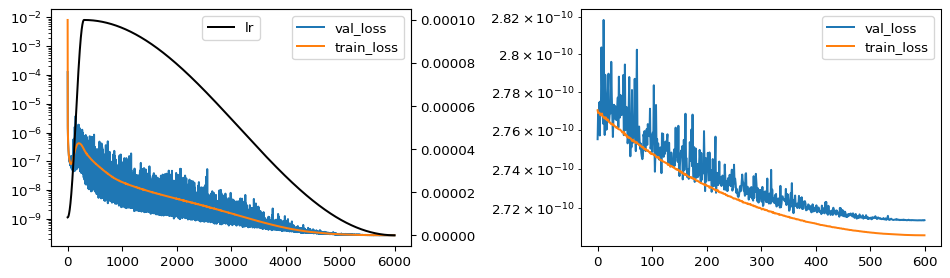

In [37]:
fig,ax=plt.subplots(1,2,figsize=(10,3),dpi=96)
ax[0].semilogy(history['val_loss'],label='val_loss')
ax[0].semilogy(history['train_loss'],label='train_loss')
ax[0].legend()
axx = ax[0].twinx()
axx.plot(history['lr'],label='lr',color='k')
axx.legend(loc='upper center')

ax[1].semilogy(history['val_loss'][-int(0.1*EPOCHs):],label='val_loss')
ax[1].semilogy(history['train_loss'][-int(0.1*EPOCHs):],label='train_loss')
ax[1].legend()
fig.tight_layout()

In [38]:
np.min(history['train_loss']), np.min(history['val_loss'])

(2.705849276038742e-10, 2.713484365787354e-10)

# loaded model test, w jit, 

In [39]:
model_info = json.load(open(MODEL_PATH + 'model_info.json','r'))
scalar = util.scalar(fname=MODEL_PATH + 'scalar_info.pkl')

### model time cost

##### w/o JIT

In [40]:
model, _ = util.construct_model(**model_info)
model.to('cpu').to(DTYPE);
model.load_state_dict(torch.load(MODEL_PATH+'model.pt',map_location=torch.device('cpu')))
model.eval();

In [41]:
test_x = torch.tensor(xn[:1,:],dtype=DTYPE)

def test():
    model(test_x)
t = timeit.Timer(test)
dt = t.timeit(number=100000)/100000
print('dt:',dt*1e6,'micro-sec')

dt: 159.10887932404876 micro-sec


##### w JIT

In [42]:
model, _ = util.construct_model(**model_info)
model.to('cpu').to(DTYPE);
my_script_module = torch.jit.script(model)
my_script_module.load_state_dict(torch.load(MODEL_PATH+'model.pt',map_location=torch.device('cpu')))
my_script_module.eval();

In [43]:
def test():
    my_script_module(test_x)
t = timeit.Timer(test)
dt = t.timeit(number=100000)/100000
print('dt:',dt*1e6,'micro-sec')

dt: 132.05509452149272 micro-sec


# validation

In [44]:
nval = int(validation_split*len(x))
xval = xn[:nval]
yval = yn[:nval]
yval_true_phys = y[:nval]

xval.shape, yval.shape, yval_true_phys.shape

((40265318, 4), (40265318, 2), (40265318, 2))

In [45]:
BATCH_SIZE, nval, len(x)

(8192, 40265318, 134217728)

In [46]:
nbatch = int(len(xval)/BATCH_SIZE)
yval_pred = []
for i in range(nbatch):
    i1 = i*BATCH_SIZE
    i2 = i1+BATCH_SIZE
    x_ = torch.tensor(xval[i1:i2,:],dtype=DTYPE)
    with torch.no_grad():
        yval_pred.append( my_script_module(x_).cpu().numpy() )
        
x_ = torch.tensor(xval[i2:,:],dtype=DTYPE)
with torch.no_grad():
    yval_pred.append( my_script_module(x_).cpu().numpy() )
    
yval_pred_phys = scalar.unnormalize_y(np.concatenate(yval_pred,axis=0))

In [47]:
yval_pred_phys.shape, yval_true_phys.shape

((40265318, 2), (40265318, 2))

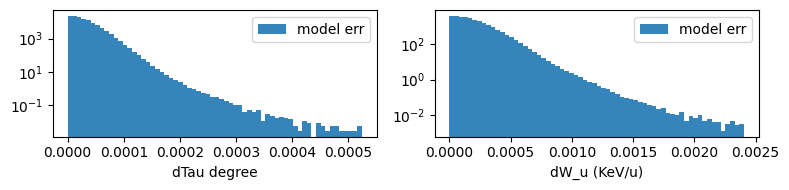

In [48]:
diff_model = np.abs(yval_pred_phys-yval_true_phys)

fig,ax = plt.subplots(1,2,figsize=(8,2))
ax[0].hist(diff_model[:,0]/np.pi*180,bins=64,label='model err',alpha=0.9,density=True)
ax[0].legend()
ax[0].set_yscale('log')
ax[0].set_xlabel(Y_LABELs[0]+" degree")

ax[1].hist(diff_model[:,1]*1e-5,bins=64,label='model err',alpha=0.9,density=True)
ax[1].legend()
ax[1].set_yscale('log')
ax[1].set_xlabel(Y_LABELs[1]+" (KeV/u)")

fig.tight_layout()
fig.savefig(MODEL_PATH+'plot_validation.png',dpi=64)